In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from hacktops.data import generate_top_dataset

top_ = 'CONRAD'
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")

In [2]:
dataset = generate_top_dataset(df_logs=df_logs_, df_tops=df_tops_, top=top_)

NAN FOUND
NAN FOUND
NAN FOUND
NAN FOUND


Window size = 61 samples


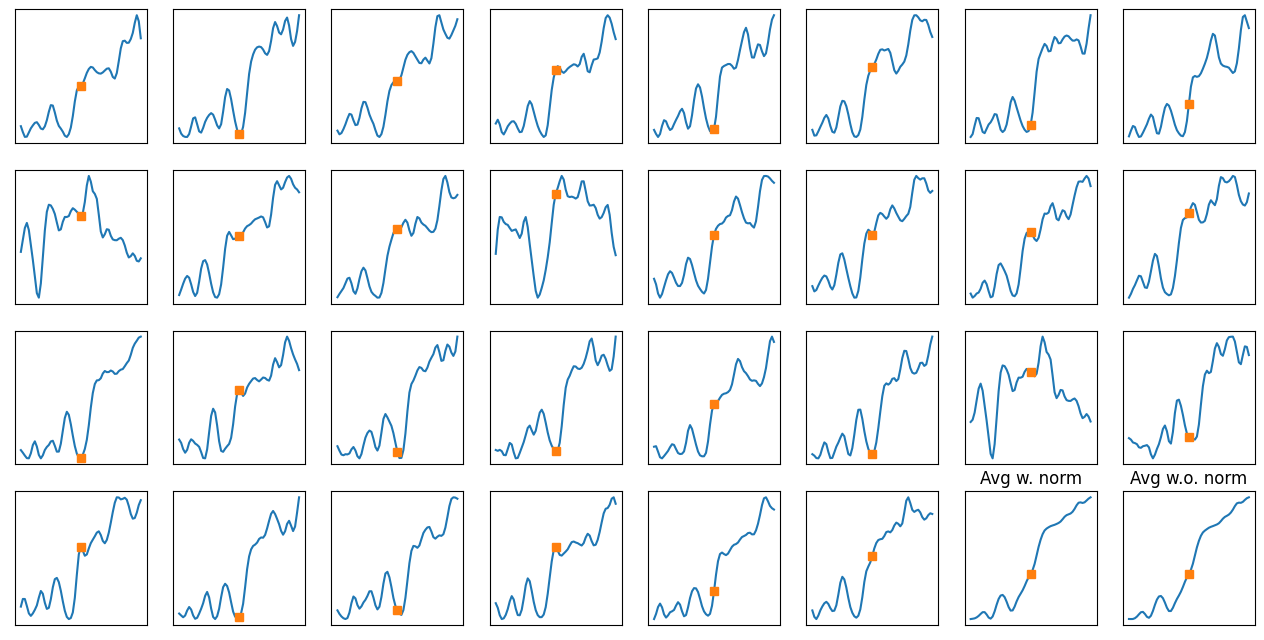

In [25]:
from hacktops.settings import WINDOW_LENGTH
from sklearn.preprocessing import normalize

def random_sample_n(X, k):
    samples = random.sample(X, k=k)
    return samples

# TODO: some alternatives of normalization to try
# Instance normalization
# 1. (data-center_value)/(max-min)
# 2. (data-avg)/(max-min)
# global normalization
# 1. (data-avg_of_center_value)/(max-min)
# 2. (data-avg_of_all)/(max-min)
def instance_norm(sample):
    center = int((len(sample)-1)/2)
    s = (sample-sample[center]) / (np.max(sample) - np.min(sample)+1)
    return s

def avg_window(samples: np.ndarray, normalize:bool = False):
    '''normalize: normalize the data using (data-center_value)/(max-min)
    '''
    if normalize:
        normalized = [instance_norm(sample) for sample in samples]
        return np.average(normalized, 0)
    else:
        return np.average(samples, 0)

r = 30  # 0 to 30
dataset_clipped = [[sample[WINDOW_LENGTH-r:WINDOW_LENGTH+r+1] for sample in dataset[0]], dataset[1]]
true_samples = [dataset_clipped[0][i] for i in range(len(dataset_clipped[0])) if dataset_clipped[1][i]==True]
samples = random_sample_n(true_samples, 32)
fig, axes = plt.subplots(4, 8, figsize=(16,8))
center = len(samples[0])/2
print("Window size =", 2*r+1, 'samples' )
for i, ax in enumerate(axes.flat[:-2]):
    data = samples[i]
    ax.plot(range(len(data)), data)
    ax.plot([r], [samples[i][r]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

ax = axes.flat[-1]  
data = avg_window(samples[:-2])
ax.plot(range(len(data)), data)
ax.plot([r], [data[r]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Avg w.o. norm')


ax = axes.flat[-2]  
data = avg_window(samples[:-2], normalize=True)
ax.plot(range(len(data)), data)
ax.plot([r], [data[r]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Avg w. norm')

plt.show()

# The GR measure increases when the depth passes through the top
# The little fluctuations in the left side seem to be a useful pattern

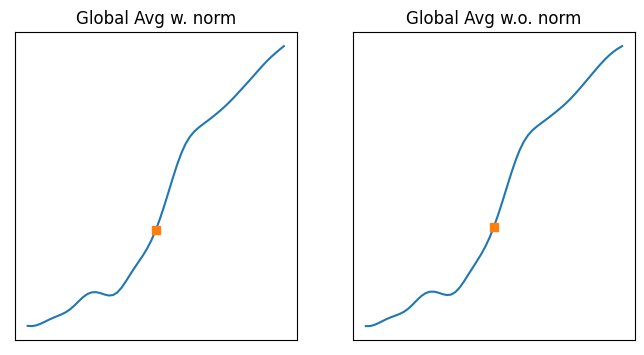

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

ax = axes.flat[-1]  
data = avg_window(true_samples)
ax.plot(range(len(data)), data)
ax.plot([r], [data[r]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Global Avg w.o. norm')


ax = axes.flat[-2]  
data = avg_window(true_samples, normalize=True)
ax.plot(range(len(data)), data)
ax.plot([r], [data[r]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Global Avg w. norm')

plt.show()

In [18]:
top_depth_gr = []
for wellname in df_tops_.index.to_list():
        df_temp = df_logs_[df_logs_["wellName"] == wellname]
        true_top = df_tops_.loc[wellname][top_] 
        if true_top > 0:    
            true_log = df_temp[df_temp["DEPTH"] == true_top]
            if len(true_log) == 0:
                # print(f'well({wellname} top({topname}) consistency check fails')
                continue
            top_depth_gr.append([true_log['DEPTH'].iloc[0], true_log['GR'].iloc[0]])  
top_depth_gr = np.array(top_depth_gr)

In [19]:
print(np.min(top_depth_gr, axis=0))
print(np.average(top_depth_gr, axis=0))
print(np.max(top_depth_gr, axis=0))

[6189.       16.0405]
[6678.33447099   74.4082058 ]
[7086.      193.2597]


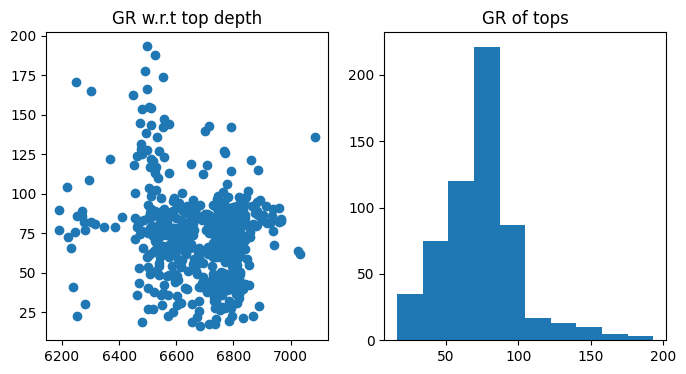

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

ax = axes.flat[-1]  
ax.hist(top_depth_gr[:,1])
ax.set_title('GR of tops')

ax = axes.flat[-2]  
ax.scatter(top_depth_gr[:,0], top_depth_gr[:,1])
ax.set_title('GR w.r.t top depth')

plt.show()

# The GRs in the depth of tops are dense between 25 to 100. 
# We should keep this info in the model 
# What is more inportant? absolute value or the trend

X: (119010, 61)
y: (119010,)


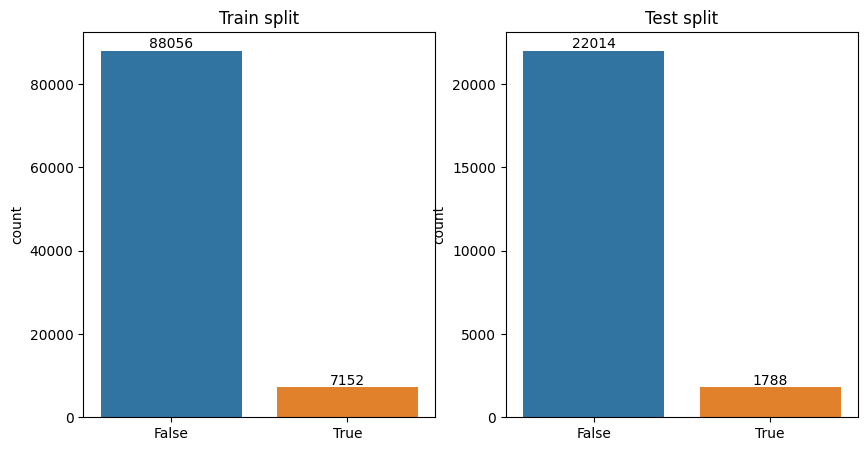

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import numpy as np

# X = np.array([np.array(i) for i in dataset[0]])
X = np.array(dataset_clipped[0]).squeeze(axis=2)
y = np.array(dataset_clipped[1])

normalize = True
if normalize:
    X = np.array([instance_norm(x) for x in X])
    
print('X:', X.shape)
print('y:', y.shape)

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(X, y))

fig, axes = plt.subplots(1,2, figsize=(10,5))
for split, title, ax in zip([train_index, test_index], 
                     ['Train split', 'Test split'],
                     axes.flatten()):
    sns.countplot(x=y[split], ax=ax).set_title(title)
    ax.bar_label(ax.containers[0])

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from tslearn.metrics import dtw
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier(n_neighbors=3,weights='distance', metric=dtw, n_jobs=4)

In [32]:
neigh.fit(X[train_index],y[train_index])
y_pred = neigh.predict(X[test_index])
print(classification_report(y[test_index], y_pred))